In [1]:
%load_ext autoreload
%load_ext tensorboard
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import os
import random
import yaml
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib import cm
import seaborn as sns
from importlib import reload
from pathlib import Path
import sklearn
import joblib
import torch
import pandas as pd
import copy

# Set the font to a nicer font
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "serif"

In [3]:
import scipy.stats as stats

def check_significance(model1_accuracies, model2_accuracies, alpha=0.05, paired=True):
    """
    Checks if the difference in accuracies between two models is statistically significant.

    Args:
        model1_accuracies (list): Accuracies for Model 1 across runs.
        model2_accuracies (list): Accuracies for Model 2 across runs.
        alpha (float): Significance level (default is 0.05).
        paired (bool): Whether to use a paired t-test (default is True). If False, uses an independent t-test.

    Returns:
        bool: True if the difference is statistically significant, False otherwise.
    """
    min_len = min(len(model1_accuracies), len(model2_accuracies))
    if paired:
        # Paired t-test for dependent samples
        _, p_value = stats.ttest_rel(model1_accuracies[:min_len], model2_accuracies[:min_len])
    else:
        # Independent t-test for independent samples
        _, p_value = stats.ttest_ind(model1_accuracies[:min_len], model2_accuracies[:min_len])

    return p_value < alpha

def get_metric_from_dict(results, method, metric):
    vals = []
    for _, metric_keys in results.items():
        for candidate_method, metric_map in metric_keys.items():
            if method != candidate_method:
                continue
            for metric_name, val in metric_map.items():
                if metric_name == metric:
                    vals.append(val)
    return vals


In [4]:
# Plot Hyperparameters
clrs = sns.color_palette("deep", 15)
MAIN_METHOD = "MixCEM Final All Sample"

color_map = {
    "Bayes MLP": "black",
    "Bayes Classifier": "black",
    "MixCEM (ours)": "red",
    "MixCEM (Platt Calibrated)": "red",
    "MixCEM (No Calibration)": "gray",
    "MixCEM (no IntCEM loss)": "black",
    "MixCEM + IntCEM": "orange",
    "MixIntCEM (ours)": "orange",
    "IntCEM": "cyan",
    "Logit Joint CBM": "salmon",
    "Independent CBM": "lightgreen",
    "Sequential CBM": "slateblue",
}

baselines_to_include = [
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    # "Sigmoidal CEM",
    "IntCEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "Entropy CMCMixCEM",
    "Bayes MLP",
    "Sequential CBM",
    "Independent CBM",
    "Logit Joint CBM",
]
for idx, baseline in enumerate(baselines_to_include):
    if baseline not in color_map:
        color_map[baseline] = clrs[idx]

markers = {
    "Joint CBM": '-o',
    "Vanilla CBM": '-o',
    "Sigmoidal Joint CBM": '-o',
    "Logit Joint CBM": '-v',
    "Sequential CBM": '-^',
    "Independent CBM": '-2',
    "Hybrid-CBM": '-v',
    "Hybrid CBM": '-v',
    "CEM": '-^',
    "IntCEM": '-x',
    "ProbCBM": '-s',
    "Posthoc CBM": '-p',
    "P-CBM": '-p',
    "Posthoc Hybrid CBM": '-1',
    "Hybrid Posthoc CBM": '-1',
    "Hybrid P-CBM": '-1',
    "MixCEM (ours)": '--*',
    "MixCEM (Platt Calibrated)": '--*',
    "MixCEM (No Calibration)": ':*',
    "MixCEM (no IntCEM loss)": ":*",
    "MixCEM + IntCEM": ":*",
    "MixIntCEM (ours)": ":*",
    "Bayes MLP": ":.",
    "Bayes Classifier": ":.",
}

max_limit = 10

select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'

rename_map = {
    "Entropy CMCMixIntCEM": "MixIntCEM (ours)",
    "Entropy CMCMixCEM": "MixCEM (ours)",
    MAIN_METHOD: "MixCEM (ours)",
    MAIN_METHOD + " No Calibration": "MixCEM (No Calibration)",
    "MixCEM Final All No Sample": "MixCEM (No test-time sampling)",
    "MixCEM Final Sample No Calibration": "MixCEM (No Calibration)",
    "MixCEM Final Sample": "MixCEM (Platt Calibrated)",
    "MixCEM Final": "MixCEM (ours)",
    "MixCEM Final All": "MixCEM (ours)",
    "Entropy CMCMixIntCEM No Calibration": "MixIntCEM (No Calibration)",
    "Entropy CMCMixCEM No Calibration": "MixCEM (No Calibration)",
    "MixCEM Final No Calibration": "MixCEM (No Calibration)",
    "Posthoc Hybrid CBM": "Residual P-CBM",
    "Hybrid Posthoc CBM": "Residual P-CBM",
    "Posthoc CBM": "P-CBM",
    "Bayes MLP": "Bayes Classifier",
    "Joint CBM": "Vanilla CBM",
    "Hybrid-CBM": "Hybrid CBM",
}
used_rename_map = rename_map
show_variance = True
ood_suffix = 'OOD_sap_0.1_'

In [5]:
from texttable import Texttable
import latextable
from collections import defaultdict

results_to_include = [
    dict(
        path='/anfs/bigdisc/me466/mixcem_results/cub_completeness_ablation/',
        name='CUB',
        n_concepts=112,
        n_groups=28,
    ),
]
select_metric = 'val_acc_y_random_group_level_True_use_prior_False_int_auc'
for res in results_to_include:
    res['results'] = joblib.load(os.path.join(res['path'], 'results.joblib'))
    res['selected_models'] = joblib.load(os.path.join(res['path'], f'selected_models_{select_metric}.joblib'))

baselines_to_include = [
    "DNN",
    "Joint CBM",
    "Hybrid-CBM",
    "Sigmoidal CEM",
    "ProbCBM",
    "Posthoc CBM",
    "Posthoc Hybrid CBM",
    "CEM",
    "IntCEM",
    MAIN_METHOD,
]
for dataset_results in results_to_include:
    print("****" * 10, f"{dataset_results['name']}", "****" * 10)
    for label in baselines_to_include:
        real_label = dataset_results.get('rename', {}).get(label, label)
        used_select_metric = dataset_results.get(
            'select_metric',
            select_metric,
        )
        model_name = dataset_results['selected_models'].get(
            real_label + " (Baseline)",
            real_label + " (Baseline)",
        )
        print(f"\tFor {label} we selected:", model_name)

**************************************** CUB ****************************************
	For DNN we selected: DNN (Baseline)
	For Joint CBM we selected: Joint CBM (Baseline)
	For Hybrid-CBM we selected: Hybrid-CBM (Baseline)
	For Sigmoidal CEM we selected: Sigmoidal CEM (Baseline)
	For ProbCBM we selected: ProbCBM (Baseline)
	For Posthoc CBM we selected: Posthoc CBM (Baseline)
	For Posthoc Hybrid CBM we selected: Posthoc Hybrid CBM (Baseline)
	For CEM we selected: CEM (Baseline)
	For IntCEM we selected: IntCEM (Baseline)
	For MixCEM Final All Sample we selected: MixCEM Final All Sample (Baseline)


# Chapter 4: CEMs

model_name = CBM_Sigmoid_sampling_0.1_cwl_1
model_name = CBM_Sigmoid_sampling_0.25_cwl_1
model_name = CBM_Sigmoid_sampling_0.5_cwl_1
model_name = CBM_Sigmoid_sampling_0.75_cwl_1
model_name = CBM_Sigmoid_sampling_0.9_cwl_1
model_name = CBM_Sigmoid_sampling_1_cwl_1
For Fuzzy CBM we got means [18.78667587 47.19537453 63.1170176  67.19882637 67.94960304 70.66793234]
model_name = CBM_Bool_sampling_0.1_cwl_1
model_name = CBM_Bool_sampling_0.25_cwl_1
model_name = CBM_Bool_sampling_0.5_cwl_1
model_name = CBM_Bool_sampling_0.75_cwl_1
model_name = CBM_Bool_sampling_0.9_cwl_1
model_name = CBM_Bool_sampling_1_cwl_1
For Boolean CBM we got means [16.81912323 43.3897135  55.13462202 59.86365205 61.34794615 61.43424232]


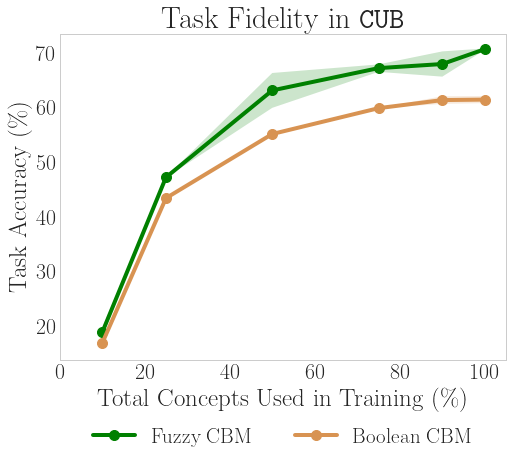

In [33]:
rc('text', usetex=True) # For quality, let's temporarily disable this
fig, ax = plt.subplots(figsize=(8, 6))
results = results_to_include[0]['results']
sampling_percents = [0.1, 0.25, 0.5, 0.75, 0.9, 1]
used_baselines_to_include = [
    ('CBM_Sigmoid_sampling_{sampling_percent}_cwl_1', 'Fuzzy CBM'),
    # ('CBM_Logit_sampling_{sampling_percent}_cwl_1', 'Logit CBM'),
    ('CBM_Bool_sampling_{sampling_percent}_cwl_1', 'Boolean CBM'),
]
color_map['Fuzzy CBM'] = 'green'
color_map['Boolean CBM'] = '#d89352' #'brown'
for idx, (model_name_template, label) in enumerate(used_baselines_to_include):
    vals = []
    for sampling_percent in sampling_percents:
        model_name = model_name_template.format(
            sampling_percent=sampling_percent
        )
        print("model_name =", model_name)
        task_acc = get_metric_from_dict(
            results,
            model_name,
            f"test_acc_y",
        )
        vals.append(task_acc)
    vals = np.array(vals)
    label = rename_map.get(label, label)
    means = np.mean(vals, axis=-1) * 100
    print("For", label, "we got means", means)
    stds = np.std(vals, axis=-1) * 100
    xticks = np.array(sampling_percents) * 100
    color = color_map.get(label, clrs[idx])
    marker = markers.get(label, "x" if "Mix" in label else "o")
    linestyle = '-'
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=10,
        linewidth=4,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
ax.set_xlim(0, 105)
ax.set_ylabel("Task Accuracy (\%)", fontsize=15+15 + -5)
ax.set_xlabel("Total Concepts Used in Training (\%)", fontsize=15+15 + -5)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.set_title(r'Task Fidelity in \texttt{CUB}', fontsize=30)
ax.grid(False)
handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=15+6,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.15),
    ncol=len(used_baselines_to_include),
)
plt.savefig(f"../figures/thesis/completeness_ablation{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/thesis/completeness_ablation{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()
rc('text', usetex=True)


model_name = CBM_Sigmoid_sampling_0.1_cwl_1
model_name = CBM_Sigmoid_sampling_0.25_cwl_1
model_name = CBM_Sigmoid_sampling_0.5_cwl_1
model_name = CBM_Sigmoid_sampling_0.75_cwl_1
model_name = CBM_Sigmoid_sampling_0.9_cwl_1
model_name = CBM_Sigmoid_sampling_1_cwl_1
For Fuzzy CBM we got means [85.58878379 85.28780972 87.04174947 85.83337306 85.99552674 86.8170127 ]
model_name = CBM_Bool_sampling_0.1_cwl_1
model_name = CBM_Bool_sampling_0.25_cwl_1
model_name = CBM_Bool_sampling_0.5_cwl_1
model_name = CBM_Bool_sampling_0.75_cwl_1
model_name = CBM_Bool_sampling_0.9_cwl_1
model_name = CBM_Bool_sampling_1_cwl_1
For Boolean CBM we got means [84.92539283 86.20486455 86.77542014 86.3670102  86.36751333 86.28512405]


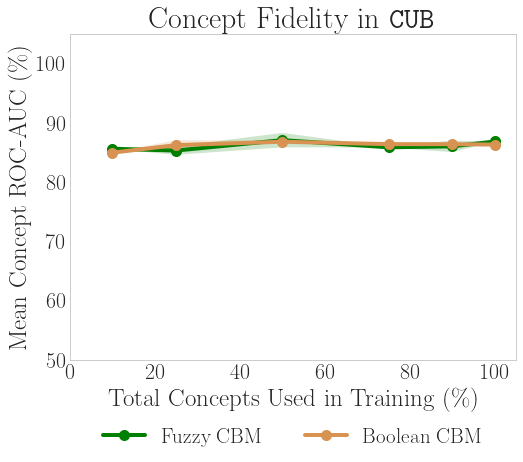

In [34]:
rc('text', usetex=True) # For quality, let's temporarily disable this
fig, ax = plt.subplots(figsize=(8, 6))
results = results_to_include[0]['results']
sampling_percents = [0.1, 0.25, 0.5, 0.75, 0.9, 1]
used_baselines_to_include = [
    ('CBM_Sigmoid_sampling_{sampling_percent}_cwl_1', 'Fuzzy CBM'),
    # ('CBM_Logit_sampling_{sampling_percent}_cwl_1', 'Logit CBM'),
    ('CBM_Bool_sampling_{sampling_percent}_cwl_1', 'Boolean CBM'),
]
color_map['Fuzzy CBM'] = 'green'
color_map['Boolean CBM'] = '#d89352' #'brown'
for idx, (model_name_template, label) in enumerate(used_baselines_to_include):
    vals = []
    for sampling_percent in sampling_percents:
        model_name = model_name_template.format(
            sampling_percent=sampling_percent
        )
        print("model_name =", model_name)
        task_acc = get_metric_from_dict(
            results,
            model_name,
            f"test_auc_c",
        )
        vals.append(task_acc)
    vals = np.array(vals)
    label = rename_map.get(label, label)
    means = np.mean(vals, axis=-1) * 100
    print("For", label, "we got means", means)
    stds = np.std(vals, axis=-1) * 100
    xticks = np.array(sampling_percents) * 100
    color = color_map.get(label, clrs[idx])
    marker = markers.get(label, "x" if "Mix" in label else "o")
    linestyle = '-'
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=10,
        linewidth=4,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
ax.set_xlim(0, 105)
ax.set_ylim(50, 105)
ax.set_ylabel("Mean Concept ROC-AUC (\%)", fontsize=15+15 + -5)
ax.set_xlabel("Total Concepts Used in Training (\%)", fontsize=15+15 + -5)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.set_title(r'Concept Fidelity in \texttt{CUB}', fontsize=30)
ax.grid(False)
handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=15+6,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.15),
    ncol=len(used_baselines_to_include),
)
plt.savefig(f"../figures/thesis/completeness_ablation_concept{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/thesis/completeness_ablation_concept{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()
rc('text', usetex=True)


model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.1_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.25_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.5_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.75_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.9_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_1_cwl_1
For Hybrid-CBM ($k^\prime = 128$) we got vals [[0.70607525 0.69520193]
 [0.71211598 0.71211598]
 [0.72937522 0.71971004]
 [0.71332413 0.72281671]
 [0.72333448 0.71971004]
 [0.72178115 0.72229893]]
(6, 2)
For Hybrid-CBM ($k^\prime = 128$) we got means [70.06385916 71.21159821 72.45426303 71.80704177 72.15222644 72.20400414]
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.1_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.25_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.5_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.75_cwl_1
model_name = 

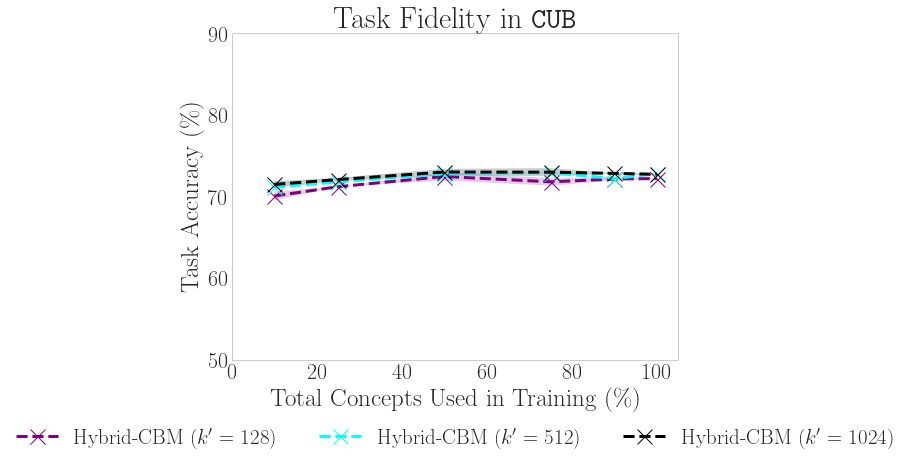

In [49]:
rc('text', usetex=True) # For quality, let's temporarily disable this
fig, ax = plt.subplots(figsize=(8, 6))
results = results_to_include[0]['results']
sampling_percents = [0.1, 0.25, 0.5, 0.75, 0.9, 1]
# sampling_percents = [0.25, 0.5]
used_baselines_to_include = [
    ('Hybrid-CBM_Sigmoid_extra_dims_128_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 128$)', 'purple'),
    ('Hybrid-CBM_Sigmoid_extra_dims_512_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 512$)', 'cyan'),
    ('Hybrid-CBM_Sigmoid_extra_dims_1024_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 1024$)', 'black'),
]
concept_loss_weight = 1
for idx, (model_name_template, label, color) in enumerate(used_baselines_to_include):
    vals = []
    for sampling_percent in sampling_percents:
        model_name = model_name_template.format(
            sampling_percent=sampling_percent,
            concept_loss_weight=concept_loss_weight,
        )
        print("model_name =", model_name)
        task_acc = get_metric_from_dict(
            results,
            model_name,
            f"test_acc_y",
        )
        vals.append(task_acc)
    vals = np.array(vals)
    print("For", label, "we got vals", vals)
    print(vals.shape)
    means = np.mean(vals, axis=-1) * 100
    print("For", label, "we got means", means)
    stds = np.std(vals, axis=-1) * 100
    xticks = np.array(sampling_percents) * 100
    if color is None:
        color = color_map.get(label, clrs[idx])
    marker = markers.get(label, "x" if "Hybrid" in label else "o")
    linestyle = '--' if "Hybrid" in label else '-'
    linewidth = 3 if "Hybrid" in label else 4 
    markersize = 15 if "Hybrid" in label else 10 
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=markersize,
        linewidth=linewidth,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
ax.set_xlim(0, 105)
ax.set_ylim(50, 90)
ax.set_ylabel("Task Accuracy (\%)", fontsize=15+15 + -5)
ax.set_xlabel("Total Concepts Used in Training (\%)", fontsize=15+15 + -5)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.set_title(r'Task Fidelity in \texttt{CUB}', fontsize=30)
ax.grid(False)
handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=15+6,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.15),
    ncol=len(used_baselines_to_include),
)
plt.savefig(f"../figures/thesis/completeness_ablation_task_hybrid_cbms{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/thesis/completeness_ablation_task_hybrid_cbms{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()
rc('text', usetex=True)


model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.1_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.25_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.5_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.75_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.9_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_1_cwl_1
For Hybrid-CBM ($k^\prime = 128$) we got vals [[0.87287004 0.86966686]
 [0.88453439 0.88290284]
 [0.87979136 0.87850945]
 [0.85922447 0.86438434]
 [0.86515003 0.8620517 ]
 [0.86021531 0.86754122]]
(6, 2)
For Hybrid-CBM ($k^\prime = 128$) we got means [87.12684497 88.37186139 87.91504041 86.18044051 86.36008625 86.38782661]
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.1_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.25_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.5_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.75_cwl_1
model_name = 

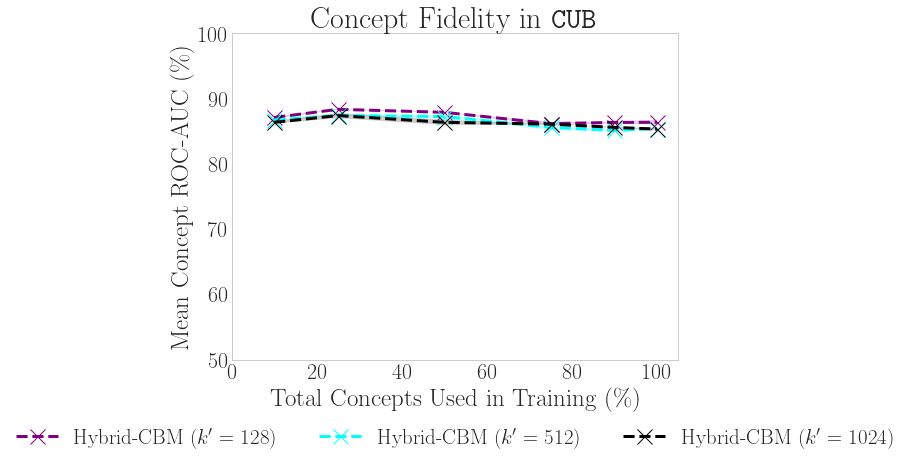

In [76]:
rc('text', usetex=True) # For quality, let's temporarily disable this
fig, ax = plt.subplots(figsize=(8, 6))
results = results_to_include[0]['results']
sampling_percents = [0.1, 0.25, 0.5, 0.75, 0.9, 1]
# sampling_percents = [0.25, 0.5]
used_baselines_to_include = [
    ('Hybrid-CBM_Sigmoid_extra_dims_128_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 128$)', 'purple'),
    ('Hybrid-CBM_Sigmoid_extra_dims_512_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 512$)', 'cyan'),
    ('Hybrid-CBM_Sigmoid_extra_dims_1024_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 1024$)', 'black'),
]
concept_loss_weight = 1
for idx, (model_name_template, label, color) in enumerate(used_baselines_to_include):
    vals = []
    for sampling_percent in sampling_percents:
        model_name = model_name_template.format(
            sampling_percent=sampling_percent,
            concept_loss_weight=concept_loss_weight,
        )
        print("model_name =", model_name)
        task_acc = get_metric_from_dict(
            results,
            model_name,
            f"test_auc_c",
        )
        vals.append(task_acc)
    vals = np.array(vals)
    print("For", label, "we got vals", vals)
    print(vals.shape)
    means = np.mean(vals, axis=-1) * 100
    print("For", label, "we got means", means)
    stds = np.std(vals, axis=-1) * 100
    xticks = np.array(sampling_percents) * 100
    if color is None:
        color = color_map.get(label, clrs[idx])
    marker = markers.get(label, "x" if "Hybrid" in label else "o")
    linestyle = '--' if "Hybrid" in label else '-'
    linewidth = 3 if "Hybrid" in label else 4 
    markersize = 15 if "Hybrid" in label else 10 
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=markersize,
        linewidth=linewidth,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
ax.set_xlim(0, 105)
ax.set_ylim(50, 100)
ax.set_ylabel("Mean Concept ROC-AUC (\%)", fontsize=15+15 + -5)
ax.set_xlabel("Total Concepts Used in Training (\%)", fontsize=15+15 + -5)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.set_title(r'Concept Fidelity in \texttt{CUB}', fontsize=30)
ax.grid(False)
handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=15+6,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.15),
    ncol=len(used_baselines_to_include),
)
plt.savefig(f"../figures/thesis/completeness_ablation_concept_hybrid_cbms{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/thesis/completeness_ablation_concept_hybrid_cbms{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()
rc('text', usetex=True)


For Hybrid-CBM ($k^\prime = 128$) we got vals [[0.72937522 0.73144632 0.73334484 0.73610632 0.7386952  0.74145668
  0.74352779 0.7454263  0.74715223 0.74905074 0.75284777 0.75509147
  0.7566448  0.75940628 0.76268554 0.76423887 0.76561961 0.76769071
  0.76907145 0.77217812 0.77511219 0.77735589 0.77908181 0.78132551
  0.78581291 0.78719365 0.78960994 0.79116327 0.79444253 0.79599586
  0.79772178 0.80048326 0.80272696 0.80617881 0.81014843 0.81204695
  0.81411805 0.81618916 0.81964101 0.82188471 0.82412841 0.82688989
  0.82965136 0.8310321  0.8332758  0.8355195  0.83724543 0.8400069
  0.84397653 0.84535727 0.84829134 0.85036244 0.85312392 0.85502244
  0.85726614 0.85864688 0.85933725]
 [0.71971004 0.72143597 0.72488781 0.72695892 0.7297204  0.73299965
  0.73541595 0.73731446 0.73852261 0.74111149 0.74352779 0.74663445
  0.74922333 0.75181222 0.7544011  0.7566448  0.7590611  0.76199517
  0.76423887 0.76751812 0.76924405 0.77062478 0.77304108 0.77511219
  0.77666552 0.78011736 0.78236106 

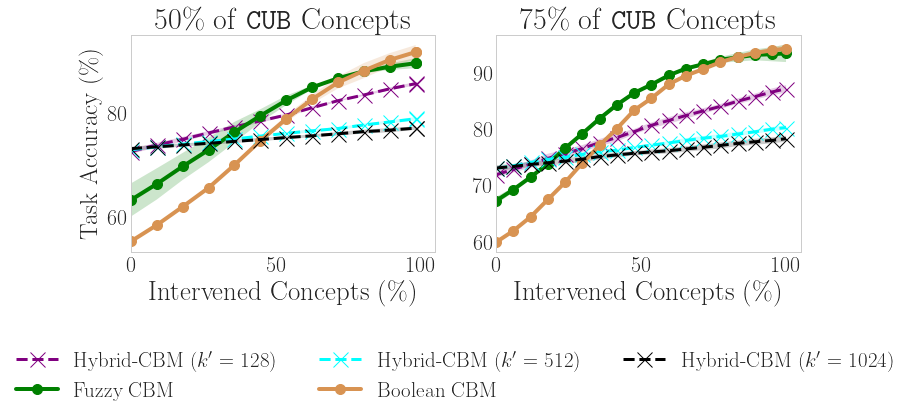

In [74]:
rc('text', usetex=True) # For quality, let's temporarily disable this
sampling_percents = [0.5, 0.75]
fig, axs = plt.subplots(1, len(sampling_percents), figsize=(12, 4), squeeze=False)
results = results_to_include[0]['results']
used_baselines_to_include = [
    ('Hybrid-CBM_Sigmoid_extra_dims_128_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 128$)', 'purple'),
    ('CBM_Sigmoid_sampling_{sampling_percent}_cwl_1', 'Fuzzy CBM', 'green'),
    ('Hybrid-CBM_Sigmoid_extra_dims_512_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 512$)', 'cyan'),
    ('CBM_Bool_sampling_{sampling_percent}_cwl_1', 'Boolean CBM', '#d89352'),
    ('Hybrid-CBM_Sigmoid_extra_dims_1024_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 1024$)', 'black'),
    # ('CBM_Logit_sampling_{sampling_percent}_cwl_1', 'Logit CBM', None),
]
concept_loss_weight = 1
freq = 5
for axis_idx, sampling_percent in enumerate(sampling_percents):
    ax = axs[0, axis_idx]
    for idx, (model_name_template, label, color) in enumerate(used_baselines_to_include):
        model_name = model_name_template.format(
            sampling_percent=sampling_percent,
            concept_loss_weight=concept_loss_weight,
        )
        vals = get_metric_from_dict(
            results,
            model_name,
            f"test_acc_y_random_group_level_False_use_prior_False_ints",
        )
        vals = np.array(vals)
        print("For", label, "we got vals", vals)
        print(vals.shape)
        means = np.mean(vals, axis=0) * 100
        print("For", label, "we got means", means)
        stds = np.std(vals, axis=0) * 100
        xticks = (
            [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
        )
        if color is None:
            color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "x" if "Mix" in label else "o")
        linestyle = '-'
        xticks = np.array(list(xticks[::freq]) + [xticks[-1]])
        means = np.array(list(means[::freq]) + [means[-1]])
        stds = np.array(list(stds[::freq]) + [stds[-1]])
        marker = markers.get(label, "x" if "Hybrid" in label else "o")
        linestyle = '--' if "Hybrid" in label else '-'
        linewidth = 3 if "Hybrid" in label else 4 
        markersize = 15 if "Hybrid" in label else 10 
        ax.plot(
            xticks,
            means,
            marker[-1:],
            color=color,
            label=label,
            linestyle=linestyle,
            markersize=markersize,
            linewidth=linewidth,
        )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, 105)
    # ax.set_ylim(50, 90)
    if axis_idx == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=15+15 + -5)
    ax.set_xlabel("Intervened Concepts (\%)", fontsize=15+15 + -3)
    ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
    ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
    ax.set_title(str(int(sampling_percent * 100)) + r"\% of \texttt{CUB} Concepts", fontsize=30)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()

# fig.suptitle(r'Task Fidelity in \texttt{CUB}', fontsize=30)
fig.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=15+6,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.15),
    ncol=3, #len(used_baselines_to_include),
)
plt.savefig(f"../figures/thesis/completeness_ablation_interventions_larger{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/thesis/completeness_ablation_interventions_larger{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()
rc('text', usetex=True)


For Hybrid-CBM ($k^\prime = 128$) we got vals [[0.72937522 0.73144632 0.73334484 0.73610632 0.7386952  0.74145668
  0.74352779 0.7454263  0.74715223 0.74905074 0.75284777 0.75509147
  0.7566448  0.75940628 0.76268554 0.76423887 0.76561961 0.76769071
  0.76907145 0.77217812 0.77511219 0.77735589 0.77908181 0.78132551
  0.78581291 0.78719365 0.78960994 0.79116327 0.79444253 0.79599586
  0.79772178 0.80048326 0.80272696 0.80617881 0.81014843 0.81204695
  0.81411805 0.81618916 0.81964101 0.82188471 0.82412841 0.82688989
  0.82965136 0.8310321  0.8332758  0.8355195  0.83724543 0.8400069
  0.84397653 0.84535727 0.84829134 0.85036244 0.85312392 0.85502244
  0.85726614 0.85864688 0.85933725]
 [0.71971004 0.72143597 0.72488781 0.72695892 0.7297204  0.73299965
  0.73541595 0.73731446 0.73852261 0.74111149 0.74352779 0.74663445
  0.74922333 0.75181222 0.7544011  0.7566448  0.7590611  0.76199517
  0.76423887 0.76751812 0.76924405 0.77062478 0.77304108 0.77511219
  0.77666552 0.78011736 0.78236106 

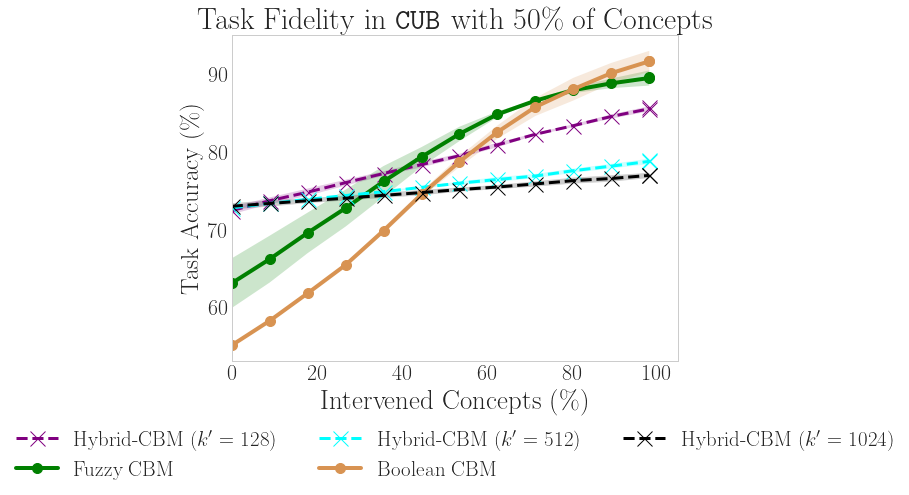

In [75]:
rc('text', usetex=True) # For quality, let's temporarily disable this
fig, ax = plt.subplots(figsize=(8, 6))
results = results_to_include[0]['results']
sampling_percent = 0.5
used_baselines_to_include = [
    ('Hybrid-CBM_Sigmoid_extra_dims_128_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 128$)', 'purple'),
    ('CBM_Sigmoid_sampling_{sampling_percent}_cwl_1', 'Fuzzy CBM', 'green'),
    ('Hybrid-CBM_Sigmoid_extra_dims_512_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 512$)', 'cyan'),
    ('CBM_Bool_sampling_{sampling_percent}_cwl_1', 'Boolean CBM', '#d89352'),
    ('Hybrid-CBM_Sigmoid_extra_dims_1024_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 1024$)', 'black'),
    # ('CBM_Logit_sampling_{sampling_percent}_cwl_1', 'Logit CBM', None),
]
concept_loss_weight = 1
freq = 5
for idx, (model_name_template, label, color) in enumerate(used_baselines_to_include):
    model_name = model_name_template.format(
        sampling_percent=sampling_percent,
        concept_loss_weight=concept_loss_weight,
    )
    vals = get_metric_from_dict(
        results,
        model_name,
        f"test_acc_y_random_group_level_False_use_prior_False_ints",
    )
    vals = np.array(vals)
    print("For", label, "we got vals", vals)
    print(vals.shape)
    means = np.mean(vals, axis=0) * 100
    print("For", label, "we got means", means)
    stds = np.std(vals, axis=0) * 100
    xticks = (
        [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
    )
    if color is None:
        color = color_map.get(label, clrs[idx])
    marker = markers.get(label, "x" if "Mix" in label else "o")
    linestyle = '-'
    xticks = np.array(list(xticks[::freq]) + [xticks[-1]])
    means = np.array(list(means[::freq]) + [means[-1]])
    stds = np.array(list(stds[::freq]) + [stds[-1]])
    marker = markers.get(label, "x" if "Hybrid" in label else "o")
    linestyle = '--' if "Hybrid" in label else '-'
    linewidth = 3 if "Hybrid" in label else 4 
    markersize = 15 if "Hybrid" in label else 10 
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=markersize,
        linewidth=linewidth,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
ax.set_xlim(0, 105)
# ax.set_ylim(50, 90)
ax.set_ylabel("Task Accuracy (\%)", fontsize=15+15 + -5)
ax.set_xlabel("Intervened Concepts (\%)", fontsize=15+15 + -3)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.set_title(r'Task Fidelity in \texttt{CUB} with ' + str(int(sampling_percent * 100)) + "\% of Concepts", fontsize=30)
ax.grid(False)
handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=15+6,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.15),
    ncol=3, #len(used_baselines_to_include),
)
plt.savefig(f"../figures/thesis/completeness_ablation_interventions{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/thesis/completeness_ablation_interventions{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()
rc('text', usetex=True)


model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.1_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.25_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.5_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.75_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_0.9_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_128_sampling_1_cwl_1
For Hybrid-CBM ($k^\prime = 128$) we got vals [[0.70607525 0.69520193]
 [0.71211598 0.71211598]
 [0.72937522 0.71971004]
 [0.71332413 0.72281671]
 [0.72333448 0.71971004]
 [0.72178115 0.72229893]]
(6, 2)
For Hybrid-CBM ($k^\prime = 128$) we got means [70.06385916 71.21159821 72.45426303 71.80704177 72.15222644 72.20400414]
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.1_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.25_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.5_cwl_1
model_name = Hybrid-CBM_Sigmoid_extra_dims_512_sampling_0.75_cwl_1
model_name = 

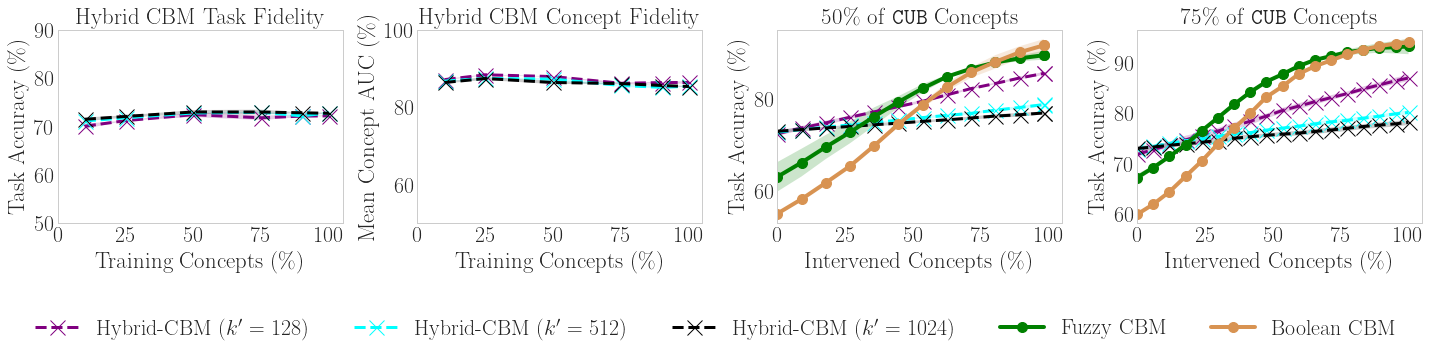

In [97]:
rc('text', usetex=True) # For quality, let's temporarily disable this
sampling_percents = [0.5, 0.75]
results = results_to_include[0]['results']
fig, axs = plt.subplots(1, 4, figsize=(20, 4), squeeze=False)

ax = axs[0, 0]
sampling_percents = [0.1, 0.25, 0.5, 0.75, 0.9, 1]
# sampling_percents = [0.25, 0.5]
used_baselines_to_include = [
    ('Hybrid-CBM_Sigmoid_extra_dims_128_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 128$)', 'purple'),
    ('Hybrid-CBM_Sigmoid_extra_dims_512_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 512$)', 'cyan'),
    ('Hybrid-CBM_Sigmoid_extra_dims_1024_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 1024$)', 'black'),
]
concept_loss_weight = 1
for idx, (model_name_template, label, color) in enumerate(used_baselines_to_include):
    vals = []
    for sampling_percent in sampling_percents:
        model_name = model_name_template.format(
            sampling_percent=sampling_percent,
            concept_loss_weight=concept_loss_weight,
        )
        print("model_name =", model_name)
        task_acc = get_metric_from_dict(
            results,
            model_name,
            f"test_acc_y",
        )
        vals.append(task_acc)
    vals = np.array(vals)
    print("For", label, "we got vals", vals)
    print(vals.shape)
    means = np.mean(vals, axis=-1) * 100
    print("For", label, "we got means", means)
    stds = np.std(vals, axis=-1) * 100
    xticks = np.array(sampling_percents) * 100
    if color is None:
        color = color_map.get(label, clrs[idx])
    marker = markers.get(label, "x" if "Hybrid" in label else "o")
    linestyle = '--' if "Hybrid" in label else '-'
    linewidth = 3 if "Hybrid" in label else 4 
    markersize = 15 if "Hybrid" in label else 10 
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=markersize,
        linewidth=linewidth,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
ax.set_xlim(0, 105)
ax.set_ylim(50, 90)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_ylabel("Task Accuracy (\%)", fontsize=15+15 + -7)
ax.set_xlabel("Training Concepts (\%)", fontsize=15+15 + -7)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
# ax.set_title(r'\texttt{CUB} Task Fidelity', fontsize=23)
ax.set_title(r'Hybrid CBM Task Fidelity', fontsize=23)
ax.grid(False)





ax = axs[0, 1]
sampling_percents = [0.1, 0.25, 0.5, 0.75, 0.9, 1]
used_baselines_to_include = [
    ('Hybrid-CBM_Sigmoid_extra_dims_128_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 128$)', 'purple'),
    ('Hybrid-CBM_Sigmoid_extra_dims_512_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 512$)', 'cyan'),
    ('Hybrid-CBM_Sigmoid_extra_dims_1024_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 1024$)', 'black'),
]
concept_loss_weight = 1
for idx, (model_name_template, label, color) in enumerate(used_baselines_to_include):
    vals = []
    for sampling_percent in sampling_percents:
        model_name = model_name_template.format(
            sampling_percent=sampling_percent,
            concept_loss_weight=concept_loss_weight,
        )
        print("model_name =", model_name)
        task_acc = get_metric_from_dict(
            results,
            model_name,
            f"test_auc_c",
        )
        vals.append(task_acc)
    vals = np.array(vals)
    print("For", label, "we got vals", vals)
    print(vals.shape)
    means = np.mean(vals, axis=-1) * 100
    print("For", label, "we got means", means)
    stds = np.std(vals, axis=-1) * 100
    xticks = np.array(sampling_percents) * 100
    if color is None:
        color = color_map.get(label, clrs[idx])
    marker = markers.get(label, "x" if "Hybrid" in label else "o")
    linestyle = '--' if "Hybrid" in label else '-'
    linewidth = 3 if "Hybrid" in label else 4 
    markersize = 15 if "Hybrid" in label else 10 
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=markersize,
        linewidth=linewidth,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
ax.set_xlim(0, 105)
ax.set_ylim(50, 100)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_ylabel("Mean Concept AUC (\%)", fontsize=15+15 + -7)
ax.set_xlabel("Training Concepts (\%)", fontsize=15+15 + -7)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
# ax.set_title(r'\texttt{CUB} Concept Fidelity', fontsize=23)
ax.set_title(r'Hybrid CBM Concept Fidelity', fontsize=23)
ax.grid(False)












sampling_percents = [0.5, 0.75]
used_baselines_to_include = [
    ('Hybrid-CBM_Sigmoid_extra_dims_128_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 128$)', 'purple'),
    ('Hybrid-CBM_Sigmoid_extra_dims_512_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 512$)', 'cyan'),
    ('Hybrid-CBM_Sigmoid_extra_dims_1024_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM ($k^\prime = 1024$)', 'black'),
    ('CBM_Sigmoid_sampling_{sampling_percent}_cwl_1', 'Fuzzy CBM', 'green'),
    ('CBM_Bool_sampling_{sampling_percent}_cwl_1', 'Boolean CBM', '#d89352'),
    # ('CBM_Logit_sampling_{sampling_percent}_cwl_1', 'Logit CBM', None),
]
concept_loss_weight = 1
freq = 5
for axis_idx, sampling_percent in enumerate(sampling_percents):
    ax = axs[0, 2 + axis_idx]
    for idx, (model_name_template, label, color) in enumerate(used_baselines_to_include):
        model_name = model_name_template.format(
            sampling_percent=sampling_percent,
            concept_loss_weight=concept_loss_weight,
        )
        vals = get_metric_from_dict(
            results,
            model_name,
            f"test_acc_y_random_group_level_False_use_prior_False_ints",
        )
        vals = np.array(vals)
        print("For", label, "we got vals", vals)
        print(vals.shape)
        means = np.mean(vals, axis=0) * 100
        print("For", label, "we got means", means)
        stds = np.std(vals, axis=0) * 100
        xticks = (
            [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
        )
        if color is None:
            color = color_map.get(label, clrs[idx])
        marker = markers.get(label, "x" if "Mix" in label else "o")
        linestyle = '-'
        xticks = np.array(list(xticks[::freq]) + [xticks[-1]])
        means = np.array(list(means[::freq]) + [means[-1]])
        stds = np.array(list(stds[::freq]) + [stds[-1]])
        marker = markers.get(label, "x" if "Hybrid" in label else "o")
        linestyle = '--' if "Hybrid" in label else '-'
        linewidth = 3 if "Hybrid" in label else 4 
        markersize = 15 if "Hybrid" in label else 10 
        ax.plot(
            xticks,
            means,
            marker[-1:],
            color=color,
            label=label,
            linestyle=linestyle,
            markersize=markersize,
            linewidth=linewidth,
        )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, 105)
    ax.set_xticks([0, 25, 50, 75, 100])
    # ax.set_ylim(50, 90)
    ax.set_ylabel("Task Accuracy (\%)", fontsize=15+15 + -7)
    ax.set_xlabel("Intervened Concepts (\%)", fontsize=15+15 + -7)
    ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
    ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
    ax.set_title(str(int(sampling_percent * 100)) + r"\% of \texttt{CUB} Concepts", fontsize=23)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()



# fig.suptitle(r'Task Fidelity in \texttt{CUB}', fontsize=30)
fig.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=15+7,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.05),
    ncol=5, #len(used_baselines_to_include),
)
plt.tight_layout()
plt.savefig(f"../figures/thesis/completeness_ablation_together{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/thesis/completeness_ablation_together{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()
rc('text', usetex=True)


model_name = CBM_Sigmoid_sampling_0.1_cwl_1
model_name = CBM_Sigmoid_sampling_0.25_cwl_1
model_name = CBM_Sigmoid_sampling_0.5_cwl_1
model_name = CBM_Sigmoid_sampling_0.75_cwl_1
model_name = CBM_Sigmoid_sampling_0.9_cwl_1
model_name = CBM_Sigmoid_sampling_1_cwl_1
For Fuzzy CBM we got vals [[0.17932344 0.19641008]
 [0.47238523 0.47152226]
 [0.66309976 0.59924059]
 [0.67880566 0.66517087]
 [0.65636866 0.7026234 ]
 [0.70797377 0.70538488]]
(6, 2)
For Fuzzy CBM we got means [18.78667587 47.19537453 63.1170176  67.19882637 67.94960304 70.66793234]
model_name = CBM_Bool_sampling_0.1_cwl_1
model_name = CBM_Bool_sampling_0.25_cwl_1
model_name = CBM_Bool_sampling_0.5_cwl_1
model_name = CBM_Bool_sampling_0.75_cwl_1
model_name = CBM_Bool_sampling_0.9_cwl_1
model_name = CBM_Bool_sampling_1_cwl_1
For Boolean CBM we got vals [[0.16499827 0.17138419]
 [0.43165343 0.43614084]
 [0.54970659 0.55298585]
 [0.59872282 0.59855022]
 [0.62046945 0.60648947]
 [0.60787021 0.62081464]]
(6, 2)
For Boolean CBM we 

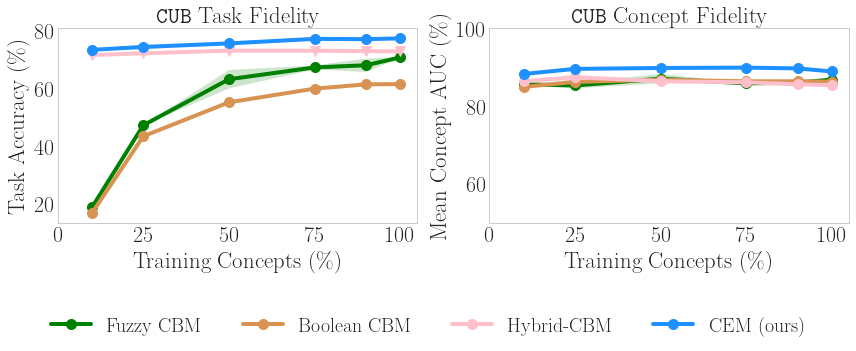

In [111]:
rc('text', usetex=True) # For quality, let's temporarily disable this
results = results_to_include[0]['results']
fig, axs = plt.subplots(1, 2, figsize=(12, 4), squeeze=False)

ax = axs[0, 0]
sampling_percents = [0.1, 0.25, 0.5, 0.75, 0.9, 1]
# sampling_percents = [0.25, 0.5]
used_baselines_to_include = [
    ('CBM_Sigmoid_sampling_{sampling_percent}_cwl_1', 'Fuzzy CBM', 'green'),
    ('CBM_Bool_sampling_{sampling_percent}_cwl_1', 'Boolean CBM', '#d89352'),
    ('Hybrid-CBM_Sigmoid_extra_dims_1024_sampling_{sampling_percent}_cwl_{concept_loss_weight}','Hybrid-CBM', 'pink'),
    ('CEM_sampling_{sampling_percent}_cwl_{concept_loss_weight}', 'CEM (ours)', 'dodgerblue'),
]
concept_loss_weight = 1
for idx, (model_name_template, label, color) in enumerate(used_baselines_to_include):
    vals = []
    for sampling_percent in sampling_percents:
        model_name = model_name_template.format(
            sampling_percent=sampling_percent,
            concept_loss_weight=concept_loss_weight,
        )
        print("model_name =", model_name)
        task_acc = get_metric_from_dict(
            results,
            model_name,
            f"test_acc_y",
        )
        vals.append(task_acc)
    vals = np.array(vals)
    print("For", label, "we got vals", vals)
    print(vals.shape)
    means = np.mean(vals, axis=-1) * 100
    print("For", label, "we got means", means)
    stds = np.std(vals, axis=-1) * 100
    xticks = np.array(sampling_percents) * 100
    if color is None:
        color = color_map.get(label, clrs[idx])
    # marker = markers.get(label, "x" if "Hybrid" in label else "o")
    # linestyle = '--' if "Hybrid" in label else '-'
    # linewidth = 3 if "Hybrid" in label else 4 
    # markersize = 15 if "Hybrid" in label else 10
    marker = markers.get(label, "o")
    linestyle = '-'
    linewidth = 4 
    markersize = 10 
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=markersize,
        linewidth=linewidth,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
ax.set_xlim(0, 105)
# ax.set_ylim(50, 90)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_ylabel("Task Accuracy (\%)", fontsize=15+15 + -7)
ax.set_xlabel("Training Concepts (\%)", fontsize=15+15 + -7)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.set_title(r'\texttt{CUB} Task Fidelity', fontsize=23)
ax.grid(False)
handles, labels = ax.get_legend_handles_labels()





ax = axs[0, 1]
for idx, (model_name_template, label, color) in enumerate(used_baselines_to_include):
    vals = []
    for sampling_percent in sampling_percents:
        model_name = model_name_template.format(
            sampling_percent=sampling_percent,
            concept_loss_weight=concept_loss_weight,
        )
        print("model_name =", model_name)
        task_acc = get_metric_from_dict(
            results,
            model_name,
            f"test_auc_c",
        )
        vals.append(task_acc)
    vals = np.array(vals)
    print("For", label, "we got vals", vals)
    print(vals.shape)
    means = np.mean(vals, axis=-1) * 100
    print("For", label, "we got means", means)
    stds = np.std(vals, axis=-1) * 100
    xticks = np.array(sampling_percents) * 100
    if color is None:
        color = color_map.get(label, clrs[idx])
    # marker = markers.get(label, "x" if "Hybrid" in label else "o")
    # linestyle = '--' if "Hybrid" in label else '-'
    # linewidth = 3 if "Hybrid" in label else 4 
    # markersize = 15 if "Hybrid" in label else 10
    marker = "o" #markers.get(label, "o")
    linestyle = '-'
    linewidth = 4 
    markersize = 10 
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=markersize,
        linewidth=linewidth,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
ax.set_xlim(0, 105)
ax.set_ylim(50, 100)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_ylabel("Mean Concept AUC (\%)", fontsize=15+15 + -7)
ax.set_xlabel("Training Concepts (\%)", fontsize=15+15 + -7)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.set_title(r'\texttt{CUB} Concept Fidelity', fontsize=23)
handles, labels = ax.get_legend_handles_labels()
ax.grid(False)


# fig.suptitle(r'Task Fidelity in \texttt{CUB}', fontsize=30)
fig.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=15+5,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.05),
    ncol=5, #len(used_baselines_to_include),
)
plt.tight_layout()
plt.savefig(f"../figures/thesis/completeness_ablation_cem{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/thesis/completeness_ablation_cem{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()
rc('text', usetex=True)


# Chapter 5: IntCEM

## RandInt Results

For CEM (with RandInt) we got vals [[0.7566448  0.75992406 0.76458405 0.76907145 0.77304108 0.7770107
  0.78201588 0.78667587 0.79116327 0.79547808 0.80013807 0.80669658
  0.81187435 0.81480842 0.82050397 0.82481878 0.82827062 0.83241284
  0.83655506 0.84121505 0.8444943  0.84811874 0.85226096 0.85674836
  0.8603728  0.86555057 0.87003797 0.87366241 0.87642389 0.87918536
  0.88211943 0.8852261  0.88902313 0.8917846  0.89540904 0.89937867
  0.90214014 0.9054194  0.90921643 0.91094235 0.91318605 0.91594753
  0.9188816  0.92198826 0.923369   0.92768381 0.92940973 0.93096307
  0.93337936 0.93493269 0.93717639 0.93959268 0.94097342 0.94304453
  0.94477045 0.94701415 0.94874008]
 [0.75353814 0.75819814 0.76285813 0.76855368 0.77321367 0.77787366
  0.78305143 0.78667587 0.7906455  0.79392475 0.80048326 0.80600621
  0.81049361 0.81584398 0.82222989 0.82550915 0.83120469 0.83534691
  0.84052468 0.84535727 0.84949948 0.8536417  0.85657577 0.86140835
  0.86641353 0.87038315 0.87487056 0.87780463 

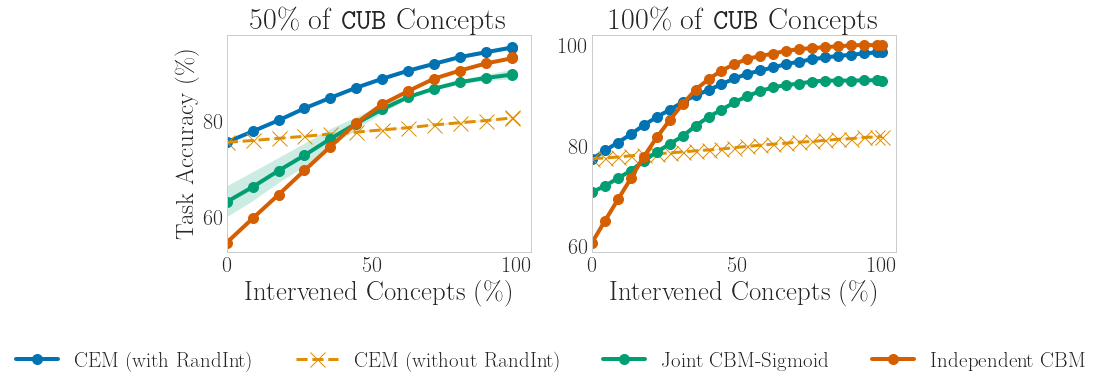

In [6]:
clrs = sns.color_palette("colorblind", 30)
rc('text', usetex=True) # For quality, let's temporarily disable this
sampling_percents = [0.5,  1]
fig, axs = plt.subplots(1, len(sampling_percents), figsize=(12, 4), squeeze=False)
results = results_to_include[0]['results']
used_baselines_to_include = [
    ('CEM_sampling_{sampling_percent}_cwl_{concept_loss_weight}', 'CEM (with RandInt)', None),
    ('CEM_no_randint_sampling_{sampling_percent}_cwl_{concept_loss_weight}', 'CEM (without RandInt)', None),
    ('CBM_Sigmoid_sampling_{sampling_percent}_cwl_1', 'Joint CBM-Sigmoid', None),
    ('CBM_Ind_sampling_{sampling_percent}', 'Independent CBM', None),
]
color_map = {}
concept_loss_weight = 1
freq = 5
for axis_idx, sampling_percent in enumerate(sampling_percents):
    ax = axs[0, axis_idx]
    for idx, (model_name_template, label, color) in enumerate(used_baselines_to_include):
        model_name = model_name_template.format(
            sampling_percent=sampling_percent,
            concept_loss_weight=concept_loss_weight,
        )
        vals = get_metric_from_dict(
            results,
            model_name,
            f"test_acc_y_random_group_level_False_use_prior_False_ints",
        )
        vals = np.array(vals)
        print("For", label, "we got vals", vals)
        print(vals.shape)
        means = np.mean(vals, axis=0) * 100
        print("For", label, "we got means", means)
        stds = np.std(vals, axis=0) * 100
        xticks = (
            [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
        )
        if color is None:
            color = color_map.get(label, clrs[idx])
        xticks = np.array(list(xticks[::freq]) + [xticks[-1]])
        means = np.array(list(means[::freq]) + [means[-1]])
        stds = np.array(list(stds[::freq]) + [stds[-1]])
        # marker = markers.get(label, "x" if "without" in label else "o")
        marker = "x" if "without" in label else "o"
        linestyle = '--' if "without" in label else '-'
        linewidth = 3 if "without" in label else 4 
        markersize = 15 if "without" in label else 10 
        ax.plot(
            xticks,
            means,
            marker[-1:],
            color=color,
            label=label,
            linestyle=linestyle,
            markersize=markersize,
            linewidth=linewidth,
        )
        # print(mode_name, label, "means =", means)
        if show_variance:
            ax.fill_between(
                xticks,
                means - stds,
                means + stds,
                alpha=0.2,
                facecolor=color,
            )
    ax.set_xlim(0, 105)
    # ax.set_ylim(50, 90)
    if axis_idx == 0:
        ax.set_ylabel("Task Accuracy (\%)", fontsize=15+15 + -5)
    ax.set_xlabel("Intervened Concepts (\%)", fontsize=15+15 + -3)
    ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
    ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
    ax.set_title(str(int(sampling_percent * 100)) + r"\% of \texttt{CUB} Concepts", fontsize=30)
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()

# fig.suptitle(r'Task Fidelity in \texttt{CUB}', fontsize=30)
fig.legend(
    handles[:len(used_baselines_to_include)],
    labels[:len(used_baselines_to_include)],
    fontsize=15+6,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.15),
    ncol=4, #len(used_baselines_to_include),
)
plt.savefig(f"../figures/thesis/completeness_ablation_randint{'_variance' if show_variance else ''}.pdf", bbox_inches='tight')
plt.savefig(f"../figures/thesis/completeness_ablation_randint{'_variance' if show_variance else ''}.png", bbox_inches='tight')
plt.show()
rc('text', usetex=True)


## Difference Across Concept Group Interventions

In [7]:
# Load CUB dataset
import cem.data.CUB200.cub_loader as cub_data_module
result_dir = "/anfs/bigdisc/me466/mixcem_results/cub_completeness_ablation/"
_, _, test_dl, imbalance, (n_concepts, n_tasks, concept_map) = \
    cub_data_module.generate_data(
        config=dict(
            dataset= "cub",
            num_workers= 8,
            batch_size= 128,
            root_dir= "/homes/me466/data/CUB200/",
            sampling_percent=1,
            sampling_groups=False,
            test_subsampling=1,
            weight_loss=True,
        ),
        seed=42,
        output_dataset_vars=True,
        root_dir='/homes/me466/data/CUB200/',
    )

Global seed set to 42


In [8]:
# Get concept groups and names
cub_group_map = cub_data_module.CONCEPT_GROUP_MAP
cub_group_map

defaultdict(list,
            {'has_bill_shape': [0, 1, 2, 3],
             'has_wing_color': [4, 5, 6, 7, 8, 9],
             'has_upperparts_color': [10, 11, 12, 13, 14, 15],
             'has_underparts_color': [16, 17, 18, 19, 20, 21],
             'has_breast_pattern': [22, 23, 24],
             'has_back_color': [25, 26, 27, 28, 29, 30],
             'has_tail_shape': [31],
             'has_upper_tail_color': [32, 33, 34, 35, 36],
             'has_head_pattern': [37, 38],
             'has_breast_color': [39, 40, 41, 42, 43, 44],
             'has_throat_color': [45, 46, 47, 48, 49],
             'has_eye_color': [50],
             'has_bill_length': [51, 52],
             'has_forehead_color': [53, 54, 55, 56, 57, 58],
             'has_under_tail_color': [59, 60, 61, 62, 63],
             'has_nape_color': [64, 65, 66, 67, 68, 69],
             'has_belly_color': [70, 71, 72, 73, 74, 75],
             'has_wing_shape': [76, 77],
             'has_size': [78, 79, 80],
        

In [ ]:
# Now include the competence that we will assume
# for all concepts
if hasattr(test_dl.dataset, 'tensors'):
    x_test, y_test, c_test = test_dl.dataset.tensors[:3]
else:
    x_test, y_test, c_test = [], [], []
    for data in test_dl:
        if len(data) == 2:
            x, (y, c) = data
        else:
            (x, y, c) = data
        x_type = x.type()
        y_type = y.type()
        c_type = c.type()
        x_test.append(x)
        y_test.append(y)
        c_test.append(c)
    x_test = torch.FloatTensor(
        np.concatenate(x_test, axis=0)
    ).type(x_type)
    y_test = torch.FloatTensor(
        np.concatenate(y_test, axis=0)
    ).type(y_type)
    c_test = torch.FloatTensor(
        np.concatenate(c_test, axis=0)
    ).type(c_type)

In [15]:
# Load model
from cem.models.construction import load_trained_model
import pytorch_lightning as pl
from cem.interventions.delta import DeltaIntPolicy

trainer = pl.Trainer(
    gpus=1,
    logger=False,
)
cub_group_names = list(cub_group_map.keys())

np.random.seed(42)
all_int_accs = []
og_accs = []
for split in [0, 1]:
    # Load the model
    cem_model_path = os.path.join(
        result_dir,
        f"CEM_sampling_1_cwl_1_fold_{split}.pt"
    )
    cem_model_config = joblib.load(
        cem_model_path.replace(f"_fold_{split}.pt", "_experiment_config.joblib"),
    )
    cem = load_trained_model(
        config=cem_model_config,
        n_tasks=n_tasks,
        result_dir=result_dir,
        n_concepts=n_concepts,
        split=split,
        imbalance=imbalance,
        task_class_weights=None,
        train_dl=None,
        logger=False,
        intervention_policy=None,
        output_latent=True,
        output_interventions=True,
        enable_checkpointing=False,
    )

    # Compute the original accuracy
    test_batch_results = trainer.predict(
        cem,
        test_dl,
    )
    y_pred = np.concatenate(
        list(map(lambda x: x[2].detach().cpu().numpy(), test_batch_results)),
        axis=0,
    )
    y_pred = np.argmax(y_pred, axis=-1)
    og_acc = np.mean(y_pred == y_test.detach().cpu().numpy())
    og_accs.append(og_acc)
    print("Original task accuracy is:", og_acc)

    # Compute the task accuracy after we intervene on all groups
    intervention_accs = []
    for j, group_name in enumerate(cub_group_names):
        ####
        # Set the model's intervention policy
        ####
        cem.intervention_policy = DeltaIntPolicy(
            cbm=cem,
            intervened_concepts=cub_group_map[group_name],
            num_groups_intervened=1,
        )
        test_batch_results = trainer.predict(
            cem,
            test_dl,
        )
        y_pred = np.concatenate(
            list(map(lambda x: x[2].detach().cpu().numpy(), test_batch_results)),
            axis=0,
        )
        y_pred = np.argmax(y_pred, axis=-1)
        acc = np.mean(y_pred == y_test.detach().cpu().numpy())
        intervention_accs.append(acc)
        print("With concept group", group_name, "we have a delta of", acc - og_acc)
    all_int_accs.append(np.array(intervention_accs))

# And package it all up nicely
all_int_accs = np.array(all_int_accs)
all_int_accs


/home/me466/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Original task accuracy is: 0.7747670003451846


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_bill_shape we have a delta of 0.013979979288919586


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_wing_color we have a delta of 0.0158784949948223


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_upperparts_color we have a delta of 0.024508111839834368


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_underparts_color we have a delta of 0.015533310321021787


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_breast_pattern we have a delta of 0.010010355540214011


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


With concept group has_back_color we have a delta of 0.014670348636520614


Predicting: 0it [00:00, ?it/s]

With concept group has_tail_shape we have a delta of 0.008802209181912324


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


With concept group has_upper_tail_color we have a delta of 0.018294787711425675


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


With concept group has_head_pattern we have a delta of 0.008457024508111921


Predicting: 0it [00:00, ?it/s]

With concept group has_breast_color we have a delta of 0.0143251639627201


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


With concept group has_throat_color we have a delta of 0.010873317224715295


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


With concept group has_eye_color we have a delta of 0.0005177770107007706


Predicting: 0it [00:00, ?it/s]

With concept group has_bill_length we have a delta of 0.008802209181912324


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_forehead_color we have a delta of 0.013117017604418413


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


With concept group has_under_tail_color we have a delta of 0.016568864342423217


Predicting: 0it [00:00, ?it/s]

With concept group has_nape_color we have a delta of 0.01328960994131867


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


With concept group has_belly_color we have a delta of 0.00897480151881258


Predicting: 0it [00:00, ?it/s]

With concept group has_wing_shape we have a delta of 0.017604418363824648


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_size we have a delta of 0.013979979288919586


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_shape we have a delta of 0.0018985157059027147


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_back_pattern we have a delta of 0.013634794615119072


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_tail_pattern we have a delta of 0.018812564722126335


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


With concept group has_belly_pattern we have a delta of 0.007248878149810234


Predicting: 0it [00:00, ?it/s]

With concept group has_primary_color we have a delta of 0.015015533310321016


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_leg_color we have a delta of 0.016223679668622704


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


With concept group has_bill_color we have a delta of 0.01328960994131867


Predicting: 0it [00:00, ?it/s]

With concept group has_crown_color we have a delta of 0.013117017604418413


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_wing_pattern we have a delta of 0.015188125647221273


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Original task accuracy is: 0.7701070072488782


Predicting: 0it [00:00, ?it/s]

With concept group has_bill_shape we have a delta of 0.015188125647221273


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_wing_color we have a delta of 0.02640662754573697


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


With concept group has_upperparts_color we have a delta of 0.02226441146013114


Predicting: 0it [00:00, ?it/s]

With concept group has_underparts_color we have a delta of 0.01846738004832582


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


With concept group has_breast_pattern we have a delta of 0.011391094235415955


Predicting: 0it [00:00, ?it/s]

With concept group has_back_color we have a delta of 0.014152571625819843


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_tail_shape we have a delta of 0.006903693476009609


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


With concept group has_upper_tail_color we have a delta of 0.022437003797031396


Predicting: 0it [00:00, ?it/s]

With concept group has_head_pattern we have a delta of 0.005695547117707922


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_breast_color we have a delta of 0.015705902657921933


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_throat_color we have a delta of 0.00897480151881258


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_eye_color we have a delta of 0.00017259233690025688


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


With concept group has_bill_length we have a delta of 0.009665170866413497


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


With concept group has_forehead_color we have a delta of 0.010873317224715184


Predicting: 0it [00:00, ?it/s]

With concept group has_under_tail_color we have a delta of 0.02278218847083191


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_nape_color we have a delta of 0.018294787711425564


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


With concept group has_belly_color we have a delta of 0.009665170866413497


Predicting: 0it [00:00, ?it/s]

With concept group has_wing_shape we have a delta of 0.01898515705902659


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_size we have a delta of 0.012081463583016872


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_shape we have a delta of 0.0020711080428028605


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_back_pattern we have a delta of 0.0143251639627201


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


With concept group has_tail_pattern we have a delta of 0.017604418363824648


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


With concept group has_belly_pattern we have a delta of 0.007076285812909866


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


With concept group has_primary_color we have a delta of 0.015705902657921933


Predicting: 0it [00:00, ?it/s]

With concept group has_leg_color we have a delta of 0.01846738004832582


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

With concept group has_bill_color we have a delta of 0.015015533310321016


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


With concept group has_crown_color we have a delta of 0.009837763203313754


Predicting: 0it [00:00, ?it/s]

With concept group has_wing_pattern we have a delta of 0.02226441146013114


array([[0.78874698, 0.7906455 , 0.79927511, 0.79030031, 0.78477736,
        0.78943735, 0.78356921, 0.79306179, 0.78322402, 0.78909216,
        0.78564032, 0.77528478, 0.78356921, 0.78788402, 0.79133586,
        0.78805661, 0.7837418 , 0.79237142, 0.78874698, 0.77666552,
        0.78840179, 0.79357957, 0.78201588, 0.78978253, 0.79099068,
        0.78805661, 0.78788402, 0.78995513],
       [0.78529513, 0.79651363, 0.79237142, 0.78857439, 0.7814981 ,
        0.78425958, 0.7770107 , 0.79254401, 0.77580255, 0.78581291,
        0.77908181, 0.7702796 , 0.77977218, 0.78098032, 0.7928892 ,
        0.78840179, 0.77977218, 0.78909216, 0.78218847, 0.77217812,
        0.78443217, 0.78771143, 0.77718329, 0.78581291, 0.78857439,
        0.78512254, 0.77994477, 0.79237142]])

In [17]:
all_int_accs.shape

(2, 28)

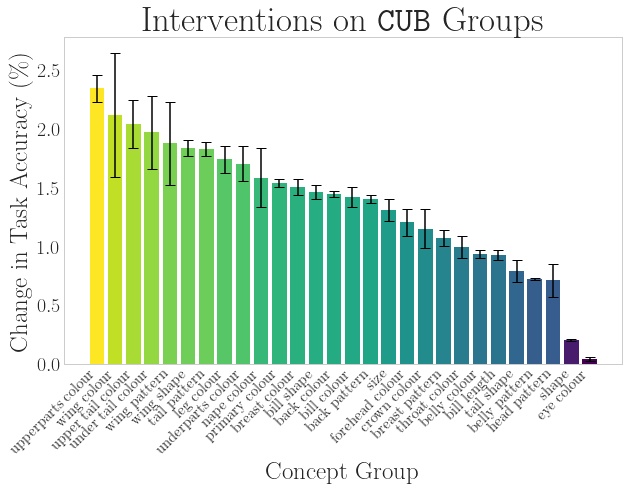

In [32]:
import matplotlib.colors as mcolors

rc('text', usetex=True) # For quality, let's temporarily disable this
# Compute mean and std across folds (axis=1)
means = ((all_int_accs - np.expand_dims(og_accs, -1)) * 100).mean(axis=0)
stds = ((all_int_accs - np.expand_dims(og_accs, -1)) * 100).std(axis=0)

# Sort indices by mean in descending order
sorted_indices = np.argsort(-means)
sorted_means = means[sorted_indices]
sorted_stds = stds[sorted_indices]
sorted_names = [cub_group_names[i].replace("has_", "").replace("_", " ").replace("color", "colour") for i in sorted_indices]

# Normalize means for colormap (0–1 range)
norm = mcolors.Normalize(vmin=sorted_means.min(), vmax=sorted_means.max())
colormap = cm.viridis  # Choose your colormap here
colours = colormap(norm(sorted_means))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(range(len(sorted_means)), sorted_means, yerr=sorted_stds, capsize=5, color=colours)
ax.set_xticks(range(len(sorted_means)), sorted_names, rotation=45, ha='right')
ax.set_ylabel("Change in Task Accuracy (\%)", fontsize=25)
ax.set_xlabel("Concept Group", fontsize=25)
ax.set_title(r"Interventions on \texttt{CUB} Groups", fontsize=35)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=20)
ax.grid(False)

plt.tight_layout()
plt.savefig(f"../figures/thesis/cub_intervention_group_effect.pdf", bbox_inches='tight')
plt.savefig(f"../figures/thesis/cub_intervention_group_effect.png", bbox_inches='tight')
plt.show()


## Intervention Policy Comparison

label is UCP
label is CooP
label is CVA
label is CVI
label is Random
label is Random
label is CooP
label is Skyline (Oracle Optimal)


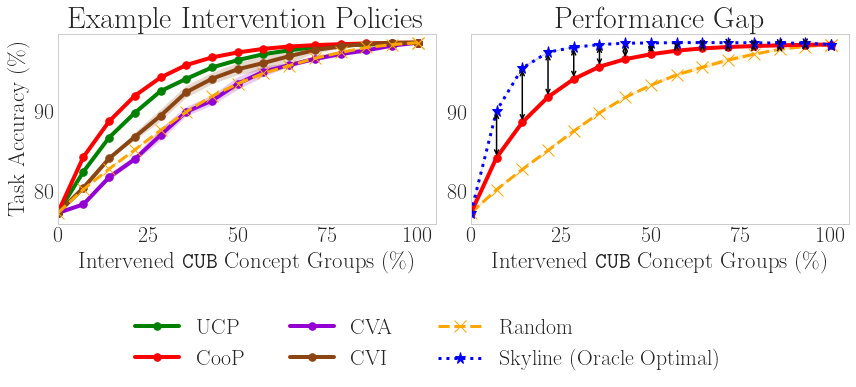

In [85]:
rc('text', usetex=True) # For quality, let's temporarily disable this
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax = axs[0]

color_map = {
    'Skyline (Oracle Optimal)': 'blue',
    'Random': 'orange',
    "UCP": 'green',
    'CooP': 'red',
    'CVA': 'darkviolet',
    'CVI': 'saddlebrown',
}
freq = 2

model_name = 'CEM_sampling_1_cwl_1'
for idx, (policy_name, label) in enumerate([
    (f"test_acc_y_uncertainty_group_level_True_use_prior_False_ints", "UCP"),
    (f"test_acc_y_coop_group_level_True_use_prior_False_ints", "CooP"),
    (f"test_acc_y_global_val_error_group_level_True_use_prior_False_ints", "CVA"),
    (f"test_acc_y_global_val_improvement_group_level_True_use_prior_False_ints", "CVI"),
    (f"test_acc_y_random_group_level_True_use_prior_False_ints", "Random"),
    # (f"test_acc_y_optimal_greedy_group_level_True_use_prior_False_ints", "Skyline (Oracle Optimal)"),
]):
    vals = get_metric_from_dict(
        results,
        model_name,
        policy_name,
    )
    vals = np.array(vals)
    means = np.mean(vals, axis=0) * 100
    stds = np.std(vals, axis=0) * 100
    xticks = (
        [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
    )
    color = color_map.get(label, clrs[idx])
    marker = markers.get(label, "x" if "Mix" in label else "o")
    linestyle = '-'
    xticks = np.array(list(xticks[::freq]) + [xticks[-1]])
    means = np.array(list(means[::freq]) + [means[-1]])
    stds = np.array(list(stds[::freq]) + [stds[-1]])
    marker = "x" if "Random" in label else "o" #markers.get(label, "x" if "Hybrid" in label else "o")
    linestyle = '--' if "Random" in label else '-'
    linewidth = 3 if "Random" in label else 4 
    markersize = 15*0.75 if "Random" in label else 10 *0.75
    print("label is", label)
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=markersize,
        linewidth=linewidth,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
ax.set_xlim(0, 105)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_ylabel("Task Accuracy (\%)", fontsize=15+15 + -7)
ax.set_xlabel(r"Intervened \texttt{CUB} Concept Groups (\%)", fontsize=15+15 + -7)
ax.set_title(r"Example Intervention Policies", fontsize=15+15)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.grid(False)
handles, labels = ax.get_legend_handles_labels()


ax = axs[1]
for idx, (policy_name, label) in enumerate([
    (f"test_acc_y_random_group_level_True_use_prior_False_ints", "Random"),
    (f"test_acc_y_coop_group_level_True_use_prior_False_ints", "CooP"),
    (f"test_acc_y_optimal_greedy_group_level_True_use_prior_False_ints", "Skyline (Oracle Optimal)"),
]):
    vals = get_metric_from_dict(
        results,
        model_name,
        policy_name,
    )
    vals = np.array(vals)
    old_means = means
    means = np.mean(vals, axis=0) * 100
    stds = np.std(vals, axis=0) * 100
    xticks = (
        [0] + list(100 * np.arange(1.0/(len(means) - 1), 1, 1.0/(len(means) - 1)))
    )
    color = color_map.get(label, clrs[idx])
    marker = markers.get(label, "x" if "Mix" in label else "o")
    linestyle = '-'
    xticks = np.array(list(xticks[::freq]) + [xticks[-1]])
    means = np.array(list(means[::freq]) + [means[-1]])
    stds = np.array(list(stds[::freq]) + [stds[-1]])
    if "Random" in label:
        marker = "x" if "Random" in label else "o" #markers.get(label, "x" if "Hybrid" in label else "o")
        linestyle = '--' if "Random" in label else '-'
        linewidth = 3 if "Random" in label else 4 
        markersize = 15*0.75 if "Random" in label else 10 *0.75
    else:
        marker = "*" if "Optimal" in label else "o"
        linestyle = ':' if "Optimal" in label else '-'
        linewidth = 3 if "Optimal" in label else 4 
        markersize = 15*0.75 if "Optimal" in label else 10*0.75 
    print("label is", label)
    ax.plot(
        xticks,
        means,
        marker[-1:],
        color=color,
        label=label,
        linestyle=linestyle,
        markersize=markersize,
        linewidth=linewidth,
    )
    # print(mode_name, label, "means =", means)
    if show_variance:
        ax.fill_between(
            xticks,
            means - stds,
            means + stds,
            alpha=0.2,
            facecolor=color,
        )
    if "Optimal" in label:
        for x_idx, x in enumerate(xticks):
            ax.annotate(
                '', 
                xy=(x, old_means[x_idx]), 
                xytext=(x, means[x_idx]),
                arrowprops=dict(arrowstyle='<->', color='black', lw=1.5)
            )
new_handles, new_labels = ax.get_legend_handles_labels()
labels.append(new_labels[-1])
handles.append(new_handles[-1])

ax.set_xlim(0, 105)
ax.set_xticks([0, 25, 50, 75, 100])
# ax.set_ylabel("Task Accuracy (\%)", fontsize=15+15 + -7)
ax.set_title(r"Performance Gap", fontsize=15+15)
ax.set_xlabel(r"Intervened \texttt{CUB} Concept Groups (\%)", fontsize=15+15 + -7)
ax.xaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.yaxis.set_tick_params(labelsize=12 + 13 + -3)
ax.grid(False)

fig.legend(
    handles,
    labels,
    fontsize=15+7,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.05),
    ncol=3,
)


plt.tight_layout()
plt.savefig(f"../figures/thesis/cub_policy_examples.pdf", bbox_inches='tight')
plt.savefig(f"../figures/thesis/cub_policy_examples.png", bbox_inches='tight')
plt.show()

In [45]:
for y in [x for x in results['0']['CEM_sampling_1_cwl_1'].keys() if 'test_acc_' in x]:
    print(y)

test_acc_c
test_acc_y
test_acc_y_random_group_level_False_use_prior_False_ints
test_acc_y_random_group_level_False_use_prior_False_int_auc
test_acc_y_random_group_level_True_use_prior_False_ints
test_acc_y_optimal_greedy_group_level_True_use_prior_False_ints
test_acc_y_global_val_error_group_level_True_use_prior_False_ints
test_acc_y_global_val_improvement_group_level_True_use_prior_False_ints
test_acc_y_uncertainty_group_level_True_use_prior_False_ints
test_acc_y_coop_group_level_True_use_prior_False_ints
test_acc_y_random_group_level_True_use_prior_False_int_auc
test_acc_y_optimal_greedy_group_level_True_use_prior_False_int_auc
test_acc_y_global_val_error_group_level_True_use_prior_False_int_auc
test_acc_y_global_val_improvement_group_level_True_use_prior_False_int_auc
test_acc_y_uncertainty_group_level_True_use_prior_False_int_auc
test_acc_y_coop_group_level_True_use_prior_False_int_auc
